## Process Description

![Dietician](Assets/Simpy_clinic.png)

Simulate a process of dietary consultation. People visit the clinic, register at the front desk and then consult the dietician.

1. **Entity**: People arriving for dietary consultation
2. **Generator**: Generate arrivals for dietary consultation 
3. **Inter-Arrrival Time**: An exponential distribution sampled for patient arrivals  
4. **Activity**: Registration followed by consultation with dietician
5. **Activity Time**: Exponential distributions
6. **Resources**: Receptionist, dietician
7. **Queues**: People waiting for registration after arrival and for consultation after registration
8. **Sink**: Exit after consultation

Based on: https://youtu.be/jXDjrWKcu6w

### 1. Import packages

Aside from **simpy**, we need **random** to sample from random distributions.

In [14]:
import simpy
import random

### 2. Generate Arrivals

Define the generator for arrivals. This puts patients in the queue for consultation.

**Args**:
- env (Simpy environment) required
- mean_IAT (int) mean Inter-Arrival Time for generating arrivals
- meanCT2register (int) mean Cycle Time for registration
- meanCT2consult (int) mean Cycle Time for consultation
- receptionist (Simpy resource) resource
- dietician (Simpy resource) resource

**Notes**:
- Has a forever-while loop in which it:
	- Creates a patient ID and sends the patient onward on their journey, invoking the function that generates consultations with the patient's ID.
	- Has one ```yield``` statement to timeout for sampled Inter-Arrival Time, after which it increments patient ID. The ```yield``` with timeout will await the action (i.e. completion of timer), freezing until then and next resuming where it left off.

In [15]:
def generate_arrivals(env, mean_IAT, meanCT2register, meanCT2consult, receptionist, dietician):
    # Create patient zero
    patient_ID = 0

    while True:
        # Send patient on the way
        action = generate_action(env, meanCT2register, meanCT2consult, receptionist, dietician, patient_ID)
        env.process(action)

        # Calculate the inter-arrival time before next patient arrives
        delta = random.expovariate(1.0 / mean_IAT)
        yield env.timeout(delta)

        # Next patient
        patient_ID += 1

### 3. Generate Action

Define the generator for registration and consulation.

**Args**:
- env (Simpy environment) required
- mean_CT2register (int) mean registration time
- mean_CT2consult (int) mean consultation time
- receptionist (Simpy resource) resource
- dietician (Simpy resource) resource
- patient_ID (int) patient ID from the function that generates arrivals

**Notes**:
- Has a ```with``` statement to request a receptionist for registration and ```yield```s until the request is fulfilled. Then executes the registration process by timing out for sampled registration time. 
- Has a ```with``` statement to request a dietician for consultation and ```yield```s until dietician is available. Then executes the consultation process by timing out for sampled consultation time.  
- Records timestamps at: entered queue for registration, started registration, entered queue for consultation, started consultation, exited process.  

In [16]:
def generate_action(env, mean_CT2register, mean_CT2consult, receptionist, dietician, patient_ID):
    # timestamp queued for registration
    queued4registration = env.now

    # request receptionist
    with receptionist.request() as req:
        yield req

        # timestamp started registration
        startedRegistration = env.now
        print("{} started registration at {:.2f} after waiting {:.2f}".format(patient_ID, startedRegistration, 
                startedRegistration-queued4registration))

        # do! registration        
        delta_registration = random.expovariate(1.0 / mean_CT2register) 
        yield env.timeout(delta_registration)

    # timestamp queued for consultation
    queued4consultation = env.now

    # request dietician
    with dietician.request() as req:
        yield req
        
        # timestamp started consultation
        startedConsultation = env.now
        print("{} started consultation at {:.2f} after waiting {:.2f}".format(patient_ID, startedConsultation, 
                startedConsultation-queued4consultation))

        # do consultation
        delta_consultation = random.expovariate(1.0 / mean_CT2consult)
        yield env.timeout(delta_consultation)

    # timestamp exited
    exited = env.now
    print("{} left at {:.2f}".format(patient_ID, exited))

*Question*: The two ```with``` statements in ```generate_action()``` are at the same level. If one were nested within the other, how does the meaning change?

### 4. Set Up & Run Simulation

Define simulation variables as follows:
- Create an instance of env
- Initialize resources
- Define key parameters (for distributions)

In [17]:
# Set up the simulation environment
env = simpy.Environment()

# Set up the resources
receptionist = simpy.Resource(env, 1)
dietician = simpy.Resource(env, 1)

# Configure simulation parameters
mean_IAT = 5 
mean_CT2register = 6
mean_CT2consult = 8

In [18]:
env.process(generate_arrivals(env, mean_IAT, mean_CT2register, mean_CT2consult, receptionist, dietician))
env.run(until=120)

0 started registration at 0.00 after waiting 0.00
0 started consultation at 3.52 after waiting 0.00
1 started registration at 3.52 after waiting 2.71
2 started registration at 5.22 after waiting 3.42
0 left at 7.64
1 started consultation at 7.64 after waiting 2.42
1 left at 8.36
2 started consultation at 12.75 after waiting 0.00
3 started registration at 12.75 after waiting 5.12
4 started registration at 14.39 after waiting 0.44
2 left at 15.75
3 started consultation at 15.75 after waiting 1.36
5 started registration at 26.31 after waiting 7.54
6 started registration at 27.34 after waiting 3.44
3 left at 36.32
4 started consultation at 36.32 after waiting 10.01
7 started registration at 38.56 after waiting 6.35
8 started registration at 40.96 after waiting 6.59
4 left at 47.19
5 started consultation at 47.19 after waiting 19.85
5 left at 53.93
6 started consultation at 53.93 after waiting 15.38
9 started registration at 57.89 after waiting 22.61
6 left at 59.04
7 started consultation a

## Part B: Archive Data

So far we have printed out results. Now, let us save them using arrays. Define global arrays for saving timestamps. Then proceed to persist information to file.

We want to know how efficient is our process. Efficiency means minimizing wster. From a patient's vantage point, waste is time spent in queuing. We shall persist information about time spent in queuing and the lead time from arrival to exit.


### 1. Import packages

Add **matplotlib** for plotting.

In [19]:
import simpy
import random
import configuration
from matplotlib import pyplot as plt

Unable to revert mtime: /Library/Fonts


### 2. Generate Arrivals

Modify the generator for arrivals to use a new generator function to process arrivals.

In [20]:
def generate_arrivals2(env, mean_IAT, meanCT2register, meanCT2consult, receptionist, dietician):
    # Create patient zero
    patient_ID = 0

    while True:
        # Send patient on the way
        action = generate_action2(env, meanCT2register, meanCT2consult, receptionist, dietician, patient_ID)
        env.process(action)

        # Calculate the inter-arrival time before next patient arrives
        delta = random.expovariate(1.0 / mean_IAT)
        yield env.timeout(delta)

        # Next patient
        patient_ID += 1

### 3. Generate Action

Modify the function to use globals to persist information.

In [21]:
def generate_action2(env, mean_CT2register, mean_CT2consult, receptionist, dietician, patient_ID):
    # globals
    global queued4registration
    global queued4consultation
    global leadTime
    
    # timestamp queued for registration
    arrived = env.now

    # request receptionist
    with receptionist.request() as req:
        yield req

        # timestamp started registration
        startedRegistration = env.now
        print("{} started registration at {:.2f} after waiting {:.2f}".format(patient_ID, startedRegistration, 
                startedRegistration-arrived))
        queued4registration.append(startedRegistration - arrived)

        # do! registration        
        delta_registration = random.expovariate(1.0 / mean_CT2register) 
        yield env.timeout(delta_registration)

    # timestamp queued for consultation
    enteredQueue4consultation = env.now

    # request dietician
    with dietician.request() as req:
        yield req
        
        # timestamp started consultation
        startedConsultation = env.now
        print("{} started consultation at {:.2f} after waiting {:.2f}".format(patient_ID, startedConsultation, 
                startedConsultation-enteredQueue4consultation))
        queued4consultation.append(startedConsultation-enteredQueue4consultation)

        # do consultation
        delta_consultation = random.expovariate(1.0 / mean_CT2consult)
        yield env.timeout(delta_consultation)

    # timestamp exited
    exited = env.now
    print("{} left at {:.2f}".format(patient_ID, exited))
    leadTime.append(exited-arrived)

### 4. Set Up & Run Simulation

Initialize the globals.

In [22]:
# Set up the simulation environment
env = simpy.Environment()

# Set up the resources
receptionist = simpy.Resource(env, 1)
dietician = simpy.Resource(env, 2)

# Configure simulation parameters
mean_IAT = 5 
mean_CT2register = 6
mean_CT2consult = 8

# Globals
queued4registration = []
queued4consultation = []
leadTime = []

In [23]:
# Make it so!
env.process(generate_arrivals2(env, mean_IAT, mean_CT2register, mean_CT2consult, receptionist, dietician))
env.run(until=240)

0 started registration at 0.00 after waiting 0.00
0 started consultation at 0.69 after waiting 0.00
1 started registration at 0.69 after waiting 0.16
0 left at 4.36
1 started consultation at 9.92 after waiting 0.00
2 started registration at 9.92 after waiting 5.80
2 started consultation at 9.93 after waiting 0.00
3 started registration at 9.93 after waiting 0.54
4 started registration at 12.32 after waiting 0.89
5 started registration at 15.05 after waiting 2.93
1 left at 15.06
3 started consultation at 15.06 after waiting 2.74
6 started registration at 19.33 after waiting 0.00
2 left at 33.61
4 started consultation at 33.61 after waiting 18.56
7 started registration at 34.52 after waiting 0.00
3 left at 37.44
5 started consultation at 37.44 after waiting 21.61
8 started registration at 46.77 after waiting 0.63
4 left at 47.00
6 started consultation at 47.00 after waiting 24.25
5 left at 48.31
7 started consultation at 48.31 after waiting 1.54
7 left at 50.08
6 left at 55.50
8 started 

### 5. Present Results

Print lead-times.

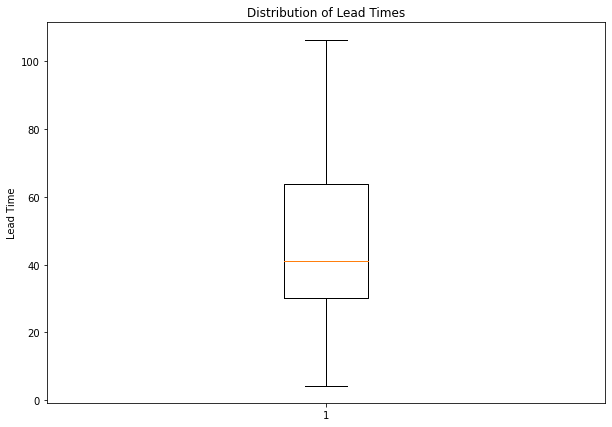

In [24]:
# Persisted info.

leadTime
fig = plt.figure(figsize=(10,7))
plt.title("Distribution of Lead Times")
plt.ylabel("Lead Time")
plt.boxplot(leadTime)
plt.show()

## Part C: Visualize Results

So far, we have gathered information about queuing time and lead time. Let us expand on the information gathered for visualization. We will modify the functions to collect more granular data. Implement the step-step process.

1. Import libraries
2. Generate Arrivals
3. Generat Action
4. Set-up & Run Simulation

In [25]:
import simpy
import random
import configuration
from matplotlib import pyplot as plt

In [26]:
def generate_arrivals3(env, mean_IAT, meanCT2register, meanCT2consult, receptionist, dietician):
    # Create patient zero
    patient_ID = 0

    while True:
        # Send patient on the way
        action = generate_action3(env, meanCT2register, meanCT2consult, receptionist, dietician, patient_ID)
        env.process(action)

        # Calculate the inter-arrival time before next patient arrives
        delta = random.expovariate(1.0 / mean_IAT)
        yield env.timeout(delta)

        # Next patient
        patient_ID += 1

In [27]:
def generate_action3(env, mean_CT2register, mean_CT2consult, receptionist, dietician, patient_ID):
    # globals
    global arrived_at_clinic
    global queued4registration
    global delta4registration
    global queued4consultation
    global delta4consultation
    global leadTime
    
    # timestamp queued for registration
    arrived = env.now
    arrived4process.append(arrived)

    # request receptionist
    with receptionist.request() as req:
        yield req

        # timestamp started registration
        startedRegistration = env.now
        queued4registration.append(startedRegistration - arrived)
        print("{} started registration at {:.2f} after waiting {:.2f}".format(patient_ID, startedRegistration, 
                startedRegistration-arrived))
        
        # do! registration        
        delta_registration = random.expovariate(1.0 / mean_CT2register)
        delta4registration.append(delta_registration)
        yield env.timeout(delta_registration)
        
        # timestamp queued for consultation
        enteredQueue4consultation = env.now

    # request dietician
    with dietician.request() as req:
        yield req
        
        # timestamp started consultation
        startedConsultation = env.now
        queued4consultation.append(startedConsultation-enteredQueue4consultation)
        print("{} started consultation at {:.2f} after waiting {:.2f}".format(patient_ID, startedConsultation, 
                startedConsultation-enteredQueue4consultation))

        # do consultation
        delta_consultation = random.expovariate(1.0 / mean_CT2consult)
        delta4consultation.append(delta_consultation)
        yield env.timeout(delta_consultation)
        
    # timestamp exited
    exited = env.now
    leadTime.append(exited-arrived)
    print("{} left at {:.2f}".format(patient_ID, exited))
    

In [28]:
# Set up the simulation environment
env = simpy.Environment()

# Set up the resources
receptionist = simpy.Resource(env, 1)
dietician = simpy.Resource(env, 2)

# Configure simulation parameters
mean_IAT = 5 
mean_CT2register = 6
mean_CT2consult = 8

# Globals
arrived4process = []
queued4registration = []
delta4registration = []
queued4consultation = []
delta4consultation = []
leadTime = []

In [29]:
# Make it so!
env.process(generate_arrivals3(env, mean_IAT, mean_CT2register, mean_CT2consult, receptionist, dietician))
env.run(until=240)

0 started registration at 0.00 after waiting 0.00
0 started consultation at 1.69 after waiting 0.00
1 started registration at 7.18 after waiting 0.00
1 started consultation at 11.20 after waiting 0.00
2 started registration at 11.20 after waiting 1.04
3 started registration at 14.21 after waiting 0.00
1 left at 14.88
2 started consultation at 14.88 after waiting 1.70
0 left at 15.05
3 started consultation at 26.60 after waiting 0.00
4 started registration at 26.60 after waiting 11.90
5 started registration at 29.18 after waiting 10.18
6 started registration at 29.21 after waiting 6.59
3 left at 29.60
4 started consultation at 29.60 after waiting 0.42
7 started registration at 36.52 after waiting 1.47
4 left at 38.11
5 started consultation at 38.11 after waiting 8.90
5 left at 40.55
6 started consultation at 40.55 after waiting 4.03
8 started registration at 41.05 after waiting 0.00
9 started registration at 43.32 after waiting 0.00
6 left at 43.68
7 started consultation at 43.68 after 

In [30]:
gantt = zip(arrived4process, leadTime)
g50 = list(gantt)[:50] 

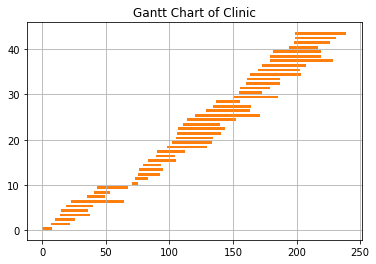

In [31]:
fig, gnt = plt.subplots()
gnt.set_title("Gantt Chart of Clinic")
gnt.grid(True)

idx_y = 0.1
for i in g50:
    gnt.broken_barh([i], (idx_y, 0.6), facecolors=('tab:orange'))
    idx_y += 1

In [32]:
sample_size = 30
gall = list(zip(arrived4process, leadTime))[:sample_size] 
greg = list(zip(arrived4process, queued4registration, delta4registration))[:sample_size]

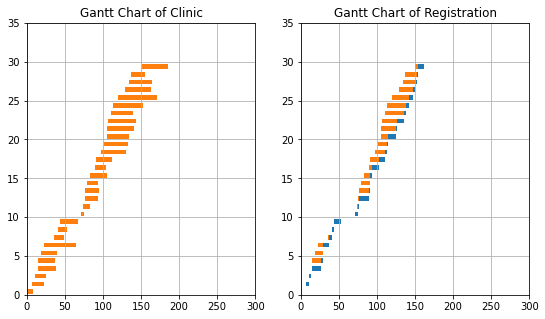

In [33]:
fig, gnt = plt.subplots(1, 2)
fig.set_figwidth(9)
fig.set_figheight(5)
gnt[0].set_title("Gantt Chart of Clinic")
gnt[0].grid(True)
gnt[0].set_ylim(0,35)
gnt[0].set_xlim(0,300)
gnt[1].set_title("Gantt Chart of Registration")
gnt[1].grid(True)
gnt[1].set_ylim(0,35)
gnt[1].set_xlim(0,300)

idx_y = 0.1
for i in gall:
    gnt[0].broken_barh([i], (idx_y, 0.6), facecolors=('tab:orange'))
    idx_y += 1

idx_y = 0.1
for i in greg:
    a, b, c = i
    gnt[1].broken_barh([(a, b)], (idx_y, 0.6), facecolors=('tab:orange'))
    gnt[1].broken_barh([(a+b, c)], (idx_y, 0.6), facecolors=('tab:blue'))
    idx_y += 1

In [34]:
sample_size = 45
gall = list(zip(arrived4process, leadTime))[:sample_size] 
greg = list(zip(arrived4process, queued4registration, delta4registration))[:sample_size]
gcon = list(zip(arrived4process, queued4registration, delta4registration, queued4consultation, delta4consultation))[:sample_size]


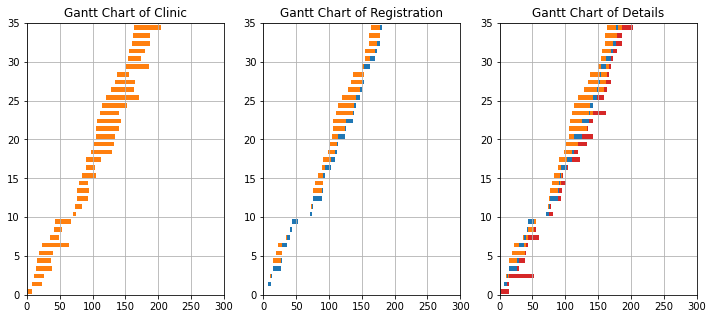

In [35]:
fig, gnt = plt.subplots(1, 3)
fig.set_figwidth(12)
fig.set_figheight(5)
gnt[0].set_title("Gantt Chart of Clinic")
gnt[0].grid(True)
gnt[0].set_ylim(0,35)
gnt[0].set_xlim(0,300)
gnt[1].set_title("Gantt Chart of Registration")
gnt[1].grid(True)
gnt[1].set_ylim(0,35)
gnt[1].set_xlim(0,300)
gnt[2].set_title("Gantt Chart of Details")
gnt[2].grid(True)
gnt[2].set_ylim(0,35)
gnt[2].set_xlim(0,300)

idx_y = 0.1
for i in gall:
    gnt[0].broken_barh([i], (idx_y, 0.6), facecolors=('tab:orange'))
    idx_y += 1

idx_y = 0.1
for i in greg:
    a, b, c = i
    gnt[1].broken_barh([(a, b)], (idx_y, 0.6), facecolors=('tab:orange'))
    gnt[1].broken_barh([(a+b, c)], (idx_y, 0.6), facecolors=('tab:blue'))
    idx_y += 1

idx_y = 0.1
for i in gcon:
    a, b, c, d, e = i
    gnt[2].broken_barh([(a, b)], (idx_y, 0.6), facecolors=('tab:orange'))
    gnt[2].broken_barh([(a+b, c)], (idx_y, 0.6), facecolors=('tab:blue'))
    gnt[2].broken_barh([(a+b+c, d)], (idx_y, 0.6), facecolors=('tab:orange'))
    gnt[2].broken_barh([(a+b+c+d, e)], (idx_y, 0.6), facecolors=('tab:red'))
    idx_y += 1

## Part D: Average Over Simulation Runs

So far, we have modeled the process, run a simulation and presented the results in the form of a Gantt chart. The process model is stochastic, i.e. it has randomness. So results will vary from one run to another. To draw meaningful conclusions, we must run multiple simulations and average over the process performance descriptors. 

We can use the generator functions as-is and run the simulation in a for loop. We will use a pandas dataframe to keep track of simulation runs. Initialize the dataframe outside the for loop and update it with the addition of a new record with computed metrics after each iteration. When the for loop has run its course, save the pandas dataframe to csv and plot the results.

Our success metric is the Lead Time or Turn-Around Time (TAT) from a patient's arrival to exit. Later, we will build a Streamlit app to see the effect of changing process parameters, e.g. adding a nurse, on the process success metrics.

In [36]:
import pandas as pd
import seaborn as sns

In [37]:
# Initialize dashboard
number_runs = 30
simulation_horizon = 240
simulation_results = []

# for loop 
for i in range(0, number_runs):
    run_result = {
        "TAT": None,
        "Queued4Registration": None,
        "Queued4Consultation": None
    }

    # Set up and run simulation
    # Set up the simulation environment
    env = simpy.Environment()

    # Set up the resources
    receptionist = simpy.Resource(env, 1)
    dietician = simpy.Resource(env, 2)

    # Configure simulation parameters
    mean_IAT = 5 
    mean_CT2register = 6
    mean_CT2consult = 8

    # Globals
    arrived4process = []
    queued4registration = []
    delta4registration = []
    queued4consultation = []
    delta4consultation = []
    leadTime = []

    # Make it so!
    env.process(generate_arrivals3(env, mean_IAT, mean_CT2register, mean_CT2consult, receptionist, dietician))
    env.run(until=simulation_horizon)

    # Update 
    run_result["TAT"] = sum(leadTime)/len(leadTime)
    run_result["Queued4Registration"] = sum(queued4registration)/len(queued4registration)
    run_result["Queued4Consultation"] = sum(queued4consultation)/len(queued4consultation)
    simulation_results.append(run_result)

# Plot & Print
df = pd.DataFrame(simulation_results)

0 started registration at 0.00 after waiting 0.00
0 started consultation at 3.81 after waiting 0.00
0 left at 5.05
1 started registration at 6.32 after waiting 0.00
1 started consultation at 6.69 after waiting 0.00
2 started registration at 10.56 after waiting 0.00
2 started consultation at 10.67 after waiting 0.00
1 left at 11.42
3 started registration at 19.18 after waiting 0.00
3 started consultation at 21.87 after waiting 0.00
4 started registration at 21.87 after waiting 0.06
2 left at 22.06
3 left at 29.27
4 started consultation at 30.48 after waiting 0.00
5 started registration at 30.48 after waiting 4.10
5 started consultation at 35.27 after waiting 0.00
6 started registration at 35.27 after waiting 5.57
5 left at 35.33
6 started consultation at 45.89 after waiting 0.00
7 started registration at 45.89 after waiting 6.33
8 started registration at 46.50 after waiting 6.92
9 started registration at 47.09 after waiting 3.88
4 left at 48.70
7 started consultation at 48.70 after wait

In [38]:
df.head()

,TAT,Queued4Registration,Queued4Consultation
0,47.044305,33.389960,3.343889
1,21.598635,9.472436,0.840366
2,55.939975,36.300468,5.223254
3,28.416079,8.340784,6.142556
4,45.450658,39.440186,0.997137


/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

Text(0.5, 0, 'Time')

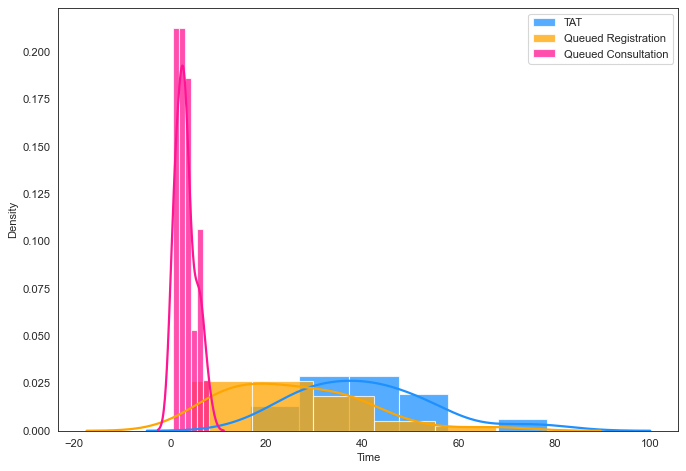

In [39]:
sns.set_style("white")
kwargs = {"hist_kws": {'alpha': 0.75}, "kde_kws": {'linewidth': 2}}
plt.figure(figsize=(10,7), dpi=80)
sns.distplot(df.TAT, color="dodgerblue", label="TAT", **kwargs)
sns.distplot(df.Queued4Registration, color="orange", label="Queued Registration", **kwargs)
sns.distplot(df.Queued4Consultation, color="deeppink", label="Queued Consultation", **kwargs)
plt.legend()
plt.xlabel("Time")

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

<AxesSubplot:xlabel='Waiting Times', ylabel='Density'>

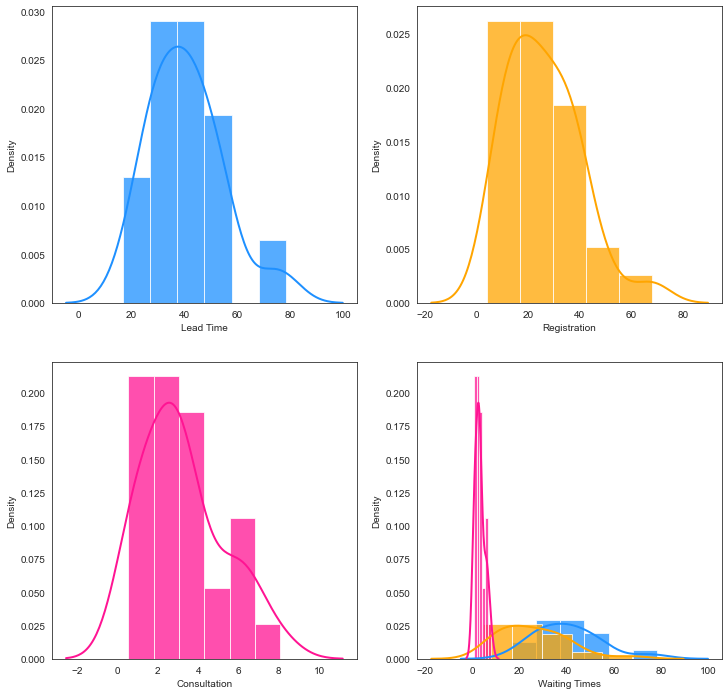

In [43]:
fig, axs = plt.subplots(2, 2)
fig.set_figwidth(12)
fig.set_figheight(12)

sns.set_style("white")
kwargs = {"hist_kws": {'alpha': 0.75}, "kde_kws": {'linewidth': 2}}
sns.distplot(df.TAT, color="dodgerblue", ax=axs[0,0], axlabel="Lead Time", **kwargs)
sns.distplot(df.Queued4Registration, color="orange", ax=axs[0,1], axlabel="Registration", **kwargs)
sns.distplot(df.Queued4Consultation, color="deeppink", ax=axs[1,0], axlabel="Consultation", **kwargs)
sns.distplot(df.TAT, color="dodgerblue", ax=axs[1,1], label="TAT", **kwargs)
sns.distplot(df.Queued4Registration, color="orange", ax=axs[1,1], label="Registration",**kwargs)
sns.distplot(df.Queued4Consultation, color="deeppink", ax=axs[1,1],  axlabel="Waiting Times", label="Consultation", **kwargs)



## Conclusions

We have arrived at a place where we can use simulation to identify bottlenecks in a process through steps as follows:
1. Model and simulate a two-step process, printing out information during simulation. Use generator functions.
2. Gather information about the process performance in a single simulation run. Use data-structures that are global in scope.
3. Visualize results from the information gathered a single simulation run. Use matplotlib library to show a gantt chart.
4. Account for stochasticity by running a set of simulation runs and averaging over process success desciptors. 

Now we can draw meaningful conclusions from the results. The historgrams and accompanying density curves about waiting times show that waiting times for consultation are smaller relative to waiting times for registration and also exhibit a relatively tighter distribution. So adding a receptionist is likely to improve the TAT. 

To perform such tweaking in real-time, we can use Streamlit.